모델 학습을 진행하기 전 데이터를 스케일링 하려고 한다.  
https://mkjjo.github.io/python/2019/01/10/scaler.html  
다음 페이지에서는 데이터 스케일링이 이런 이유로 인해 필요하다고 한다.  
데이터를 모델링하기 전에는 반드시 스케일링 과정을 거쳐야 한다.  
스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며,  
자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지하고,  
독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상 시킨다."  
그래서 스케일링의 종류에 대해 살펴보고 기온 예측에 사용되는 데이터에는 어떤 스케일링이 적절한지 모델 학습 결과로 찾아보겠다.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 불러오기
data = pd.read_csv('OBS_ASOS_DD_20210104225316.csv', encoding = 'cp949')  # 2020-01-01~2010-01-01
data1 = pd.read_csv('OBS_ASOS_DD_20210104225407.csv', encoding = 'cp949') # 2010-01-02~2020-01-02
data2 = pd.read_csv('OBS_ASOS_DD_20210104225442.csv', encoding = 'cp949') # 2020-01-03~2021-01-03

data = pd.concat([data,data1,data2],axis=0).reset_index().drop('index',axis=1)

In [3]:
# 데이터 전처리  
# 강수, 적설량과 관련된 변수는 0으로 결측 채우기  
rain_col = [i for i in data.columns if '강수' in i]
snow_col = [i for i in data.columns if '적설' in i]

data[rain_col+snow_col] = data[rain_col+snow_col].fillna(0)

data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']] = data[['안개 계속시간(hr)','합계 대형증발량(mm)','합계 소형증발량(mm)']].fillna(0)

# 사용하지 않는 컬럼 버리기
data = data.drop(['기사','강수 계속시간(hr)','10분 최다 강수량(mm)'],axis=1)

time_col=[i for i in data.columns if '시각' in i]
data = data.drop(time_col, axis=1)

data = data.drop(['지점','지점명'], axis=1)

# 시간 순서로 학습시키기 위해 시간 정렬
data = data.sort_values('일시').interpolate(method='linear')

# 보간 후 결측치 없음을 확인
print('결측치 개수 =',data.isna().sum().sum())

결측치 개수 = 0


In [4]:
# 라벨값 설정
data['Y'] = data['평균기온(°C)'].shift(-2)
data = data.dropna()

# train, valid, test dataset 분리
train = data[data['일시']<'2013-01-01']
valid = data[data['일시']>='2013-01-01']
valid = valid[valid['일시']<'2017-01-01']
test = data[data['일시']>='2017-01-01']
print(' train set:',len(train),'개\n',
      'valid set:',len(valid),'개\n',
      'test set',len(test),'개')

# X와 Y분리
trainX,trainY = train.drop(['일시','Y'],axis=1), train['Y']
validX,validY = valid.drop(['일시','Y'],axis=1), valid['Y']
testX,testY = test.drop(['일시','Y'],axis=1), test['Y']

 train set: 4749 개
 valid set: 1461 개
 test set 1462 개


#### 스케일링 대표적인 방법은 4가지가 있다.
1. Standard scaler
2. MinMax scaler
3. MaxAbs scaler
4. Robust scaler  
Scikit-Learn의 패키지를 이용하여 적용해보려한다.  

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


In [42]:
SS = StandardScaler()
SS.fit(trainX.append(validX).values)
SS_trainX = SS.transform(trainX.values)
SS_validX = SS.transform(validX.values)
SS_testX = SS.transform(testX.values)

#### DNN

In [30]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

DNN.compile(loss='mse', optimizer=optimizer)
DNN.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2250      
_________________________________________________________________
dense_16 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_18 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
_________________________________________________________

Train on 4749 samples, validate on 1461 samples
Epoch 1/200
4650/4749 [============================>.] - ETA: 0s - loss: 7509.5349 
Epoch 00001: val_loss improved from inf to 59.15887, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 98us/sample - loss: 7353.9022 - val_loss: 59.1589
Epoch 2/200
4560/4749 [===========================>..] - ETA: 0s - loss: 30.5442
Epoch 00002: val_loss improved from 59.15887 to 23.37304, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 43us/sample - loss: 30.4959 - val_loss: 23.3730
Epoch 3/200
3150/4749 [==================>...........] - ETA: 0s - loss: 20.5203
Epoch 00003: val_loss improved from 23.37304 to 15.64437, saving model to checkpoint.keras
4749/4749 [==============================] - 0s 40us/sample - loss: 19.3559 - val_loss: 15.6444
Epoch 4/200
4200/4749 [=========================>....] - ETA: 0s - loss: 15.4677
Epoch 00004: val_loss improved from 15.64437 to 13.12035, saving mo

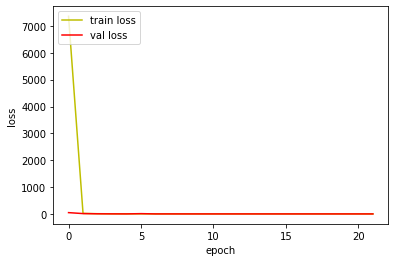

In [31]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = DNN.fit(trainX,trainY, validation_data=(validX, validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### Standard Scaler 적용

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_35 (Dense)             (None, 50)                2250      
_________________________________________________________________
dense_36 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_37 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_38 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
_________________________________________________________

Epoch 27/200
4380/4749 [==========================>...] - ETA: 0s - loss: 7.7352
Epoch 00027: val_loss did not improve from 7.47648

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
4749/4749 [==============================] - 0s 43us/sample - loss: 7.7472 - val_loss: 7.4766
Epoch 28/200
4410/4749 [==========================>...] - ETA: 0s - loss: 7.7579
Epoch 00028: val_loss did not improve from 7.47648

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000001044244145e-13.
4749/4749 [==============================] - 0s 42us/sample - loss: 7.7472 - val_loss: 7.4766
Epoch 29/200
4260/4749 [=========================>....] - ETA: 0s - loss: 7.7258
Epoch 00029: val_loss did not improve from 7.47648

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.0000001179769417e-14.
4749/4749 [==============================] - 0s 44us/sample - loss: 7.7472 - val_loss: 7.4766
Epoch 30/200
3180/4749 [===================>..........] - ETA: 0s - loss: 7.6

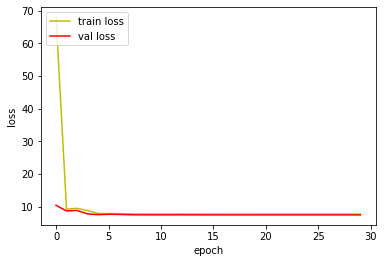

In [43]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

SS_DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

SS_DNN.compile(loss='mse', optimizer=optimizer)
SS_DNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = SS_DNN.fit(SS_trainX,trainY, validation_data=(SS_validX, validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### MinMax Scaler 적용

In [44]:
MS = MinMaxScaler()
MS.fit(trainX.append(validX).values)
MS_trainX = MS.transform(trainX.values)
MS_validX = MS.transform(validX.values)
MS_testX = MS.transform(testX.values)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 44)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 50)                2250      
_________________________________________________________________
dense_41 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_42 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_43 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
_________________________________________________________

Epoch 29/200
4740/4749 [============================>.] - ETA: 0s - loss: 7.9782
Epoch 00029: val_loss did not improve from 7.45261
4749/4749 [==============================] - 0s 40us/sample - loss: 7.9917 - val_loss: 7.4726
Epoch 30/200
4560/4749 [===========================>..] - ETA: 0s - loss: 8.0436
Epoch 00030: val_loss did not improve from 7.45261

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
4749/4749 [==============================] - 0s 41us/sample - loss: 7.9917 - val_loss: 7.4726


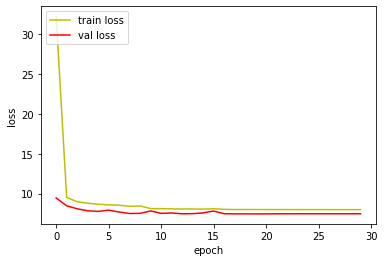

In [45]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

MS_DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

MS_DNN.compile(loss='mse', optimizer=optimizer)
MS_DNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = MS_DNN.fit(MS_trainX,trainY, validation_data=(MS_validX, validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### MaxAbs Scaler  적용

In [57]:
MAS = MaxAbsScaler()
MAS.fit(trainX.append(validX).values)
MAS_trainX = MAS.transform(trainX.values)
MAS_validX = MAS.transform(validX.values)
MAS_testX = MAS.transform(testX.values)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 44)]              0         
_________________________________________________________________
dense_50 (Dense)             (None, 50)                2250      
_________________________________________________________________
dense_51 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_52 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_53 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
________________________________________________________

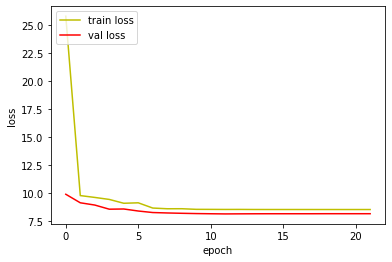

In [58]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

MAS_DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

MAS_DNN.compile(loss='mse', optimizer=optimizer)
MAS_DNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = MAS_DNN.fit(MAS_trainX,trainY, validation_data=(MAS_validX, validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

#### Robust Scaler 적용

In [61]:
RS = RobustScaler()
RS.fit(trainX.append(validX).values)
RS_trainX = RS.transform(trainX.values)
RS_validX = RS.transform(validX.values)
RS_testX = RS.transform(testX.values)

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 44)]              0         
_________________________________________________________________
dense_65 (Dense)             (None, 50)                2250      
_________________________________________________________________
dense_66 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_67 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_68 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 51        
Total params: 9,951
Trainable params: 9,951
Non-trainable params: 0
________________________________________________________

4500/4749 [===========================>..] - ETA: 0s - loss: 8.5529
Epoch 00027: val_loss improved from 8.23225 to 8.23032, saving model to checkpoint.keras

Epoch 00027: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
4749/4749 [==============================] - 0s 43us/sample - loss: 8.4884 - val_loss: 8.2303
Epoch 28/200
3180/4749 [===================>..........] - ETA: 0s - loss: 8.4604
Epoch 00028: val_loss did not improve from 8.23032
4749/4749 [==============================] - 0s 38us/sample - loss: 8.4863 - val_loss: 8.2305
Epoch 29/200
4650/4749 [============================>.] - ETA: 0s - loss: 8.5201
Epoch 00029: val_loss improved from 8.23032 to 8.23024, saving model to checkpoint.keras

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
4749/4749 [==============================] - 0s 42us/sample - loss: 8.4863 - val_loss: 8.2302
Epoch 30/200
4740/4749 [============================>.] - ETA: 0s - loss: 8.4754
Epoch 00030: va

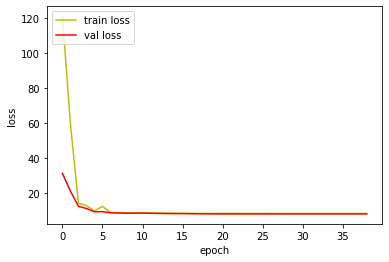

In [64]:
inputs_1 = tf.keras.Input(shape=44)
dense = tf.keras.layers.Dense(50)(inputs_1)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
dense = tf.keras.layers.Dense(50)(dense)
output = tf.keras.layers.Dense(1)(dense)

RS_DNN = tf.keras.Model(inputs=[inputs_1], outputs=output)

optimizer = tf.keras.optimizers.Adam(lr = 0.001)

RS_DNN.compile(loss='mse', optimizer=optimizer)
RS_DNN.summary()

path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', patience=10,verbose=0)


callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       patience=1,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]
hist = RS_DNN.fit(RS_trainX,trainY, validation_data=(RS_validX, validY), 
                 epochs = 200, batch_size=30, callbacks=callbacks, verbose=1)

fig, loss_ax = plt.subplots()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='upper left')

plt.show()

MAE
MAE_DNN =  2.5441033483073934
MAE_Standard =  2.1800468552857653
MAE_MinMax =  2.1815423139672925
MAE_MaxAbs =  2.273367216805489
MAE_Robust =  2.2381219682549953


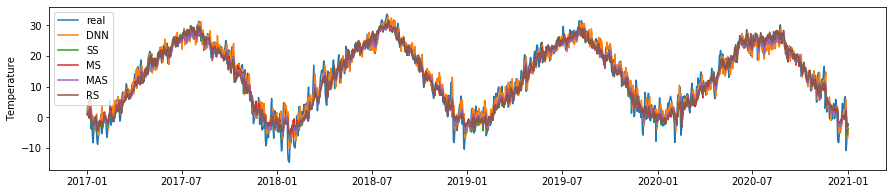

In [65]:
time = pd.to_datetime(test['일시'])

pred_DNN = DNN.predict(testX)
pred_SS = SS_DNN.predict(SS_testX)
pred_MS = MS_DNN.predict(MS_testX)
pred_MAS = MAS_DNN.predict(MAS_testX)
pred_RS = RS_DNN.predict(RS_testX)




plt.figure(figsize = (15,3))
plt.plot(time,testY.reset_index()['Y'])
plt.plot(time,pred_DNN)
plt.plot(time,pred_SS)
plt.plot(time,pred_MS)
plt.plot(time,pred_MAS)
plt.plot(time,pred_RS)



plt.ylabel('Temperature')
plt.legend(['real','DNN','SS','MS','MAS','RS'])

print('MAE')
print('MAE_DNN = ',(((testY-pred_DNN.reshape(-1,))**2)**0.5).mean())
print('MAE_Standard = ',(((testY-pred_SS.reshape(-1,))**2)**0.5).mean())
print('MAE_MinMax = ',(((testY-pred_MS.reshape(-1,))**2)**0.5).mean())
print('MAE_MaxAbs = ',(((testY-pred_MAS.reshape(-1,))**2)**0.5).mean())
print('MAE_Robust = ',(((testY-pred_RS.reshape(-1,))**2)**0.5).mean())